# Mining Masks from Shapefiles

Author: duckworthd@

This notebook shows how you can take a shapefile and use it to construct binary masks.

In [2]:
# Set root directory to nearest parent folder for this file
import os
import sys

def git_root(current_dir=None):
    """Find root directory for a github repo above 'current_dir'.
    
    Args:
        current_dir: str. Path to directory within a git repo. 
            If None, defaults to the current working directory.
            
    Returns:
        Path to parent directory containing '.git'.
        
    Raises:
        ValueError: If no parent directory contains '.git'.
    """
    result = current_dir or os.getcwd()
    while True:
        if '.git' in os.listdir(result):
            return result
        if result == "/":
            raise ValueError("Could not find parent directory containing .git.")
        result = os.path.dirname(result)

def maybe_add_to_sys_path(path):
    """Add 'path' to 'sys.path' if it's not already there."""
    if path in sys.path:
        return
    sys.path.append(path)
    
maybe_add_to_sys_path(git_root())

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import ipyleaflet
import json
import os
from duckworthd import mining
import ee; ee.Initialize()
import shapely

%matplotlib inline

In [5]:
# Load mining site masks form shapefile. For this example, we'll only use the first few.

mining_site_masks = gpd.read_file(os.path.expanduser("~/Desktop/datakind/qgis/mining_masks.shp"))
mining_site_masks = mining_site_masks.head()
mining_site_masks.head()

,pcode,geometry
0,codmine00064,"POLYGON ((29.05845782923338 1.148264452652914,..."
1,codmine00068,"POLYGON ((29.01885736771544 1.18931069978289, ..."
2,codmine00090,POLYGON ((29.29958423552241 0.8997688819361922...
3,codmine00092,"POLYGON ((29.27134246859645 0.956153502889748,..."
4,codmine00001,"POLYGON ((29.66023160078946 1.011115284854747,..."


In [6]:
# Load IPIS mining site locations. there are many more locations than masks, 
# so we'll filter down to the locations with masks.

mining_site_locations = gpd.read_file(os.path.expanduser(
    "~/Desktop/datakind/data/ipis_last_visit/cod_mines_curated_lastvisit_opendata_p_ipis.shp"))

# Select only mining site locations that have been labeled.
mining_site_locations = mining_site_locations[mining_site_locations.pcode.isin(mining_site_masks.pcode)]

mining_site_locations.head()

,vid,pcode,name,visit_date,longitude,latitude,province,province_o,territoire,collectivi,...,final_des1,armed_grou,frequency_,armed_gro0,frequency0,is_3t_mine,is_gold_mi,presence,interferen,geometry
0,585.0,codmine00001,Mayi-Tatu,2013-03-27,29.660330,1.010890,Ituri,Orientale,Irumu,Walese Vonkutu,...,None,FARDC,Permanente,None,None,0,1,1,1.0,POINT (29.66033 1.01089)
62,1683.0,codmine00064,Mabukulu,2015-06-18,29.058850,1.148350,Ituri,Orientale,Mambasa,Babila-Bakwanza,...,None,FARDC,Une fois par mois,None,None,0,1,1,1.0,POINT (29.05885 1.14835)
66,1692.0,codmine00068,Kanzambo,2015-06-19,29.019530,1.188940,Ituri,Orientale,Mambasa,Mambasa,...,None,FARDC,Une fois par mois,None,None,0,1,1,1.0,POINT (29.01953 1.18894)
87,1005.0,codmine00090,Kotakoli,2013-09-07,29.300399,0.901383,Ituri,Orientale,Mambasa,Babila-Babombi,...,None,FARDC,Permanente,None,None,0,1,1,0.0,POINT (29.300399 0.901383)
89,1004.0,codmine00092,Sinai,2013-09-07,29.271583,0.955336,Ituri,Orientale,Mambasa,Babila-Babombi,...,None,FARDC,Temporaire,None,None,0,1,1,0.0,POINT (29.271583 0.955336)


In [7]:
# Visualize mining masks. Use this to ensure that the projections for the masks
# are reasonable.

def get_center(geodataframe):
    """Get a point at the center of a geodataframe's geometry."""
    center = geodataframe.unary_union.convex_hull.centroid
    latitude = center.y
    longitude = center.x
    return (latitude, longitude)

def get_layer(geo_dataframe, color="blue", alpha=0.5):
    """Constructs a Layer based on a GeoDataFrame's geometry."""
    return ipyleaflet.GeoJSON(data=json.loads(geo_dataframe.to_json()), 
                              style={"color": color, "alpha": 0.5})

def satellite_tiles():
    """Constructs a TileLayer with using satellite imagery."""
    return ipyleaflet.TileLayer(
        url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}')

# Construct a map.
leaflet_map = ipyleaflet.Map(center=get_center(mining_site_masks), 
                             zoom=6, 
                             default_tiles=satellite_tiles())

# Add mining site locations and their accompanying masks.
leaflet_map.add_layer(get_layer(mining_site_locations, color="red", alpha=1.0))
leaflet_map.add_layer(get_layer(mining_site_masks, color="blue"))

# Add the ability to draw polygons?
def print_polygon(self, action, geo_json):
    print 'self:', self
    print 'action:', action
    print 'geo_json:', geo_json
    
draw_polygon = ipyleaflet.DrawControl(polygons={"shapeOptions": {}})
draw_polygon.on_draw(print_polygon)
leaflet_map.add_control(draw_polygon)

# Plot
leaflet_map

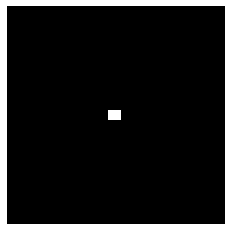

In [12]:
# Get rasterized mining site mask.
#
# This fetches a single image patch centered at a mining site location. 
# Pixels are white where the mask is active.

MINING_SITE_LOCATION_IDX = 2

from duckworthd import download_mining_masks_main

mining_site_masks_ee = download_mining_masks_main.create_earth_engine_mask(mining_site_masks)
roi_buffer = download_mining_masks_main.create_earth_engine_roi(
    mining_site_locations.iloc[MINING_SITE_LOCATION_IDX].geometry, 1500)
mask = mining.load_map_tile_containing_roi(mining_site_masks_ee, 
                                           roi_buffer.coordinates().getInfo(), 
                                           30)
mining.plot_image(mask[:, :, 0])